In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! apt remove -y openjdk-11-jre-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  java-common libpcsclite1
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  ca-certificates-java openjdk-11-jdk-headless openjdk-11-jre-headless
0 upgraded, 0 newly installed, 3 to remove and 49 not upgraded.
After this operation, 258 MB disk space will be freed.
(Reading database ... 123622 files and directories currently installed.)
Removing openjdk-11-jdk-headless:amd64 (11.0.24+8-1ubuntu3~22.04) ...
Removing openjdk-11-jre-headless:amd64 (11.0.24+8-1ubuntu3~22.04) ...
Removing ca-certificates-java (20190909ubuntu1.2) ...
Processing triggers for ca-certificates (20240203~22.04.1) ...
Updating certificates in /etc/ssl/certs...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

updates of cacerts keystore disabled.
done.


In [3]:
!apt install -y openjdk-8-jdk openjdk-8-jre

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libice-dev librsvg2-common libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1
  openjdk-8-jdk-headless openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs libice-doc libsm-doc libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei
  fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libice-dev librsvg2-common libsm-dev libxkbfile1 libxt-dev li

**Now we will first install pyspark.**

In [4]:
!pip install pyspark

**Importing libraries**

In [5]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

**Uploading the Data**

Then, we upload the data in the spark frame.

In [6]:
df = spark.read.format("csv").option("header", "true").load('/content/drive/MyDrive/Water monitoring deep learning dataset/waterquality (1).csv')
gdf = gpd.read_file('/content/drive/MyDrive/Water monitoring deep learning dataset/Igismap/Indian_States.shp')

In [7]:
df.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

In [8]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

**Data Cleaning**

In [9]:
from pyspark.sql.types import FloatType

In [11]:
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

**Now as column TOTAL_COLIFORM is not required so we will drop this column.**

In [12]:
df=df.drop('TOTAL_COLIFORM')

**Now we want to remove all the rows which contain any null value in it. So for applying a SQL query we first have to register it has a virtual temporary table and then we will issue SQL query. We are doing this because it is important to perform data cleansing steps as it will make our model to work better.**

In [13]:
df.createOrReplaceTempView("df_sql")

In [14]:
df_clean = spark.sql('''Select * from df_sql where TEMP is not null and DO is not null
                        and pH is not null and BOD is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null and FECAL_COLIFORM is not null''')

**Exploratory Data Analysis (EDA)**

Let's visualize our data.

In [15]:
df_clean.createOrReplaceTempView("df_sql")

In [16]:
do = spark.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = spark.sql("Select BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = spark.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

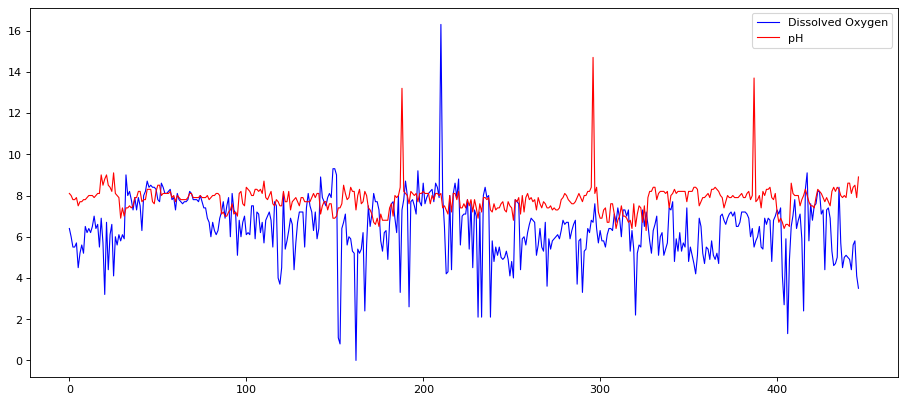

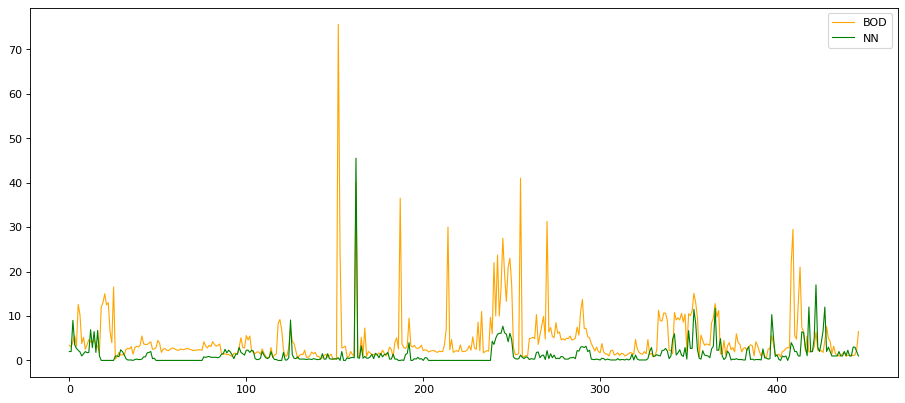

In [17]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [18]:
con = spark.sql("Select CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = spark.sql("Select FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()

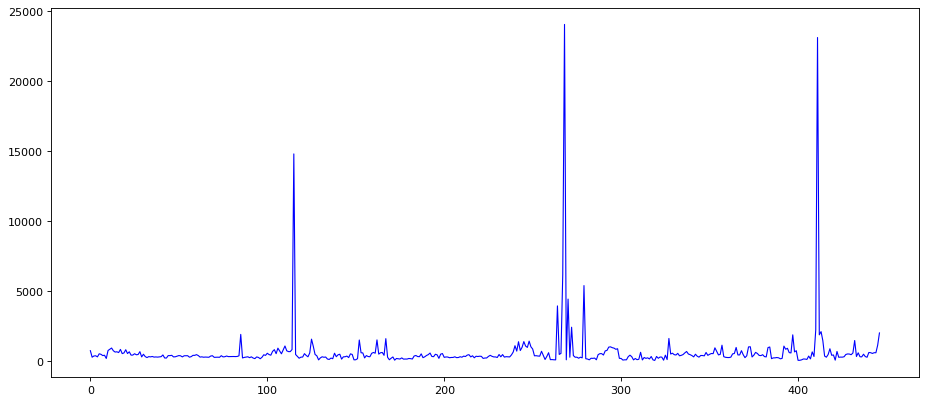

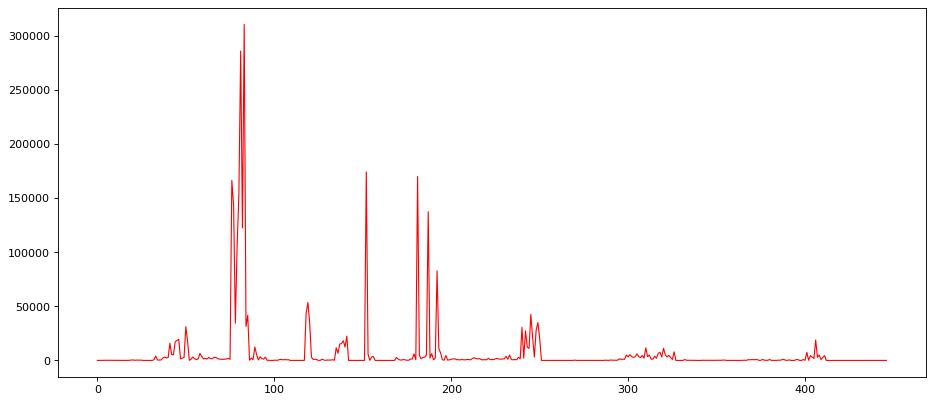

In [19]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='blue', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

**Feature Engineering**

Let us convert our data to pandas frame. We are doing this because to train a model we need what we have to predict which is not in data. So we have to calculate water quality index which requires many steps but can be easily done using pandas and in less number of steps. Also we will able to visualize our data in tabular form more effectively.

In [20]:
df=df_clean.toPandas()
df.dtypes

,0
STATION CODE,object
LOCATIONS,object
STATE,object
TEMP,float32
DO,float32
pH,float32
CONDUCTIVITY,float32
BOD,float32
NITRATE_N_NITRITE_N,float32
FECAL_COLIFORM,float32


**Initialization**

In [21]:
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]
co = df.iloc [start:end ,6].astype(np.float64)
bod = df.iloc [start:end ,7].astype(np.float64)
na= df.iloc [start:end ,8].astype(np.float64)
fc=df.iloc [2:end ,9].astype(np.float64)

In [22]:
df=pd.concat([station,location,state,do,ph,co,bod,na,fc],axis=1)
df. columns = ['station','location','state','do','ph','co','bod','na','fc']

**The Water Quality Index is calculated by aggregating the quality rating with the weight linearly,
WQI = ∑ (qn x Wn)
where qn =Quality rating for the nth Water quality parameter, Wn= unit weight for the nth parameters.
Although for calculation qn we have standard formula but it was not possible in this case, so we applied a standard method for calculating quality rating for each parameter.**

In [23]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8)
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7)
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [24]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)
                                 else(80 if  (6>=x>=5.1)
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3)
                                              else 0)))))

In [25]:
df['nco']=df.fc.apply(lambda x:(100 if (5>=x>=0)
                                 else(80 if  (50>=x>=5)
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500)
                                              else 0)))))

In [26]:
df['nbdo']=df.bod.apply(lambda x:(100 if (3>=x>=0)
                                 else(80 if  (6>=x>=3)
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80)
                                              else 0)))))

In [27]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)
                                 else(80 if  (150>=x>=75)
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225)
                                              else 0)))))

In [28]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)
                                 else(80 if  (50>=x>=20)
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100)
                                              else 0)))))

df.head()
df.dtypes

,0
station,object
location,object
state,object
do,float64
ph,float32
co,float64
bod,float64
na,float64
fc,float64
npH,int64


**Now we apply the formula of wqi by first multiplying all the quality rating with its weight and then summed all the values.**

In [29]:
df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wbdo']=df.nbdo * 0.234
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wco']=df.nco * 0.281
df['wqi']=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco
df

,station,location,state,do,ph,co,bod,na,fc,npH,...,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,3.4,2.00,NaN,100,...,80,0,100,16.5,28.10,18.72,0.00,2.8,0.00,66.12
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,3.1,2.00,NaN,100,...,80,40,100,16.5,28.10,18.72,0.36,2.8,0.00,66.48
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,4.2,9.00,59.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,5.6,3.55,90.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,3.2,2.69,45.0,100,...,80,40,100,16.5,22.48,18.72,0.36,2.8,22.48,83.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2940,"GAPE- SAGAR LAKE, DUNGARPUR, RAJASTHAN",RAJASTHAN,4.4,8.1,538.0,1.2,1.00,5.0,100,...,100,0,100,16.5,16.86,23.40,0.00,2.8,28.10,87.66
443,2941,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 1...",RAJASTHAN,5.6,8.4,591.0,1.1,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
444,2942,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 2...",RAJASTHAN,5.8,8.5,588.0,1.2,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
445,2943,"LODHA TALAB, BANSWARA- DUNGARPUR ROAD, BANSWAR...",RAJASTHAN,4.1,7.9,1133.0,2.3,2.00,7.0,100,...,100,0,100,16.5,0.00,23.40,0.00,2.8,22.48,65.18


**Then we classify the water on the basis of their water quality index.**

In [30]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)
                                 else('Good' if  (50>=x>=26)
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76)
                                              else 'Unsuitable')))))

**Let's visualize the water quality index in each state of India.**

In [31]:
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
df['state'].replace({"TAMILNADU": "TAMIL NADU"}, inplace=True)

#Capitalizing only the first letter of each word
df['state'] = df['state'].str.title()

In [32]:
!pip install mapclassify>=2.4.0

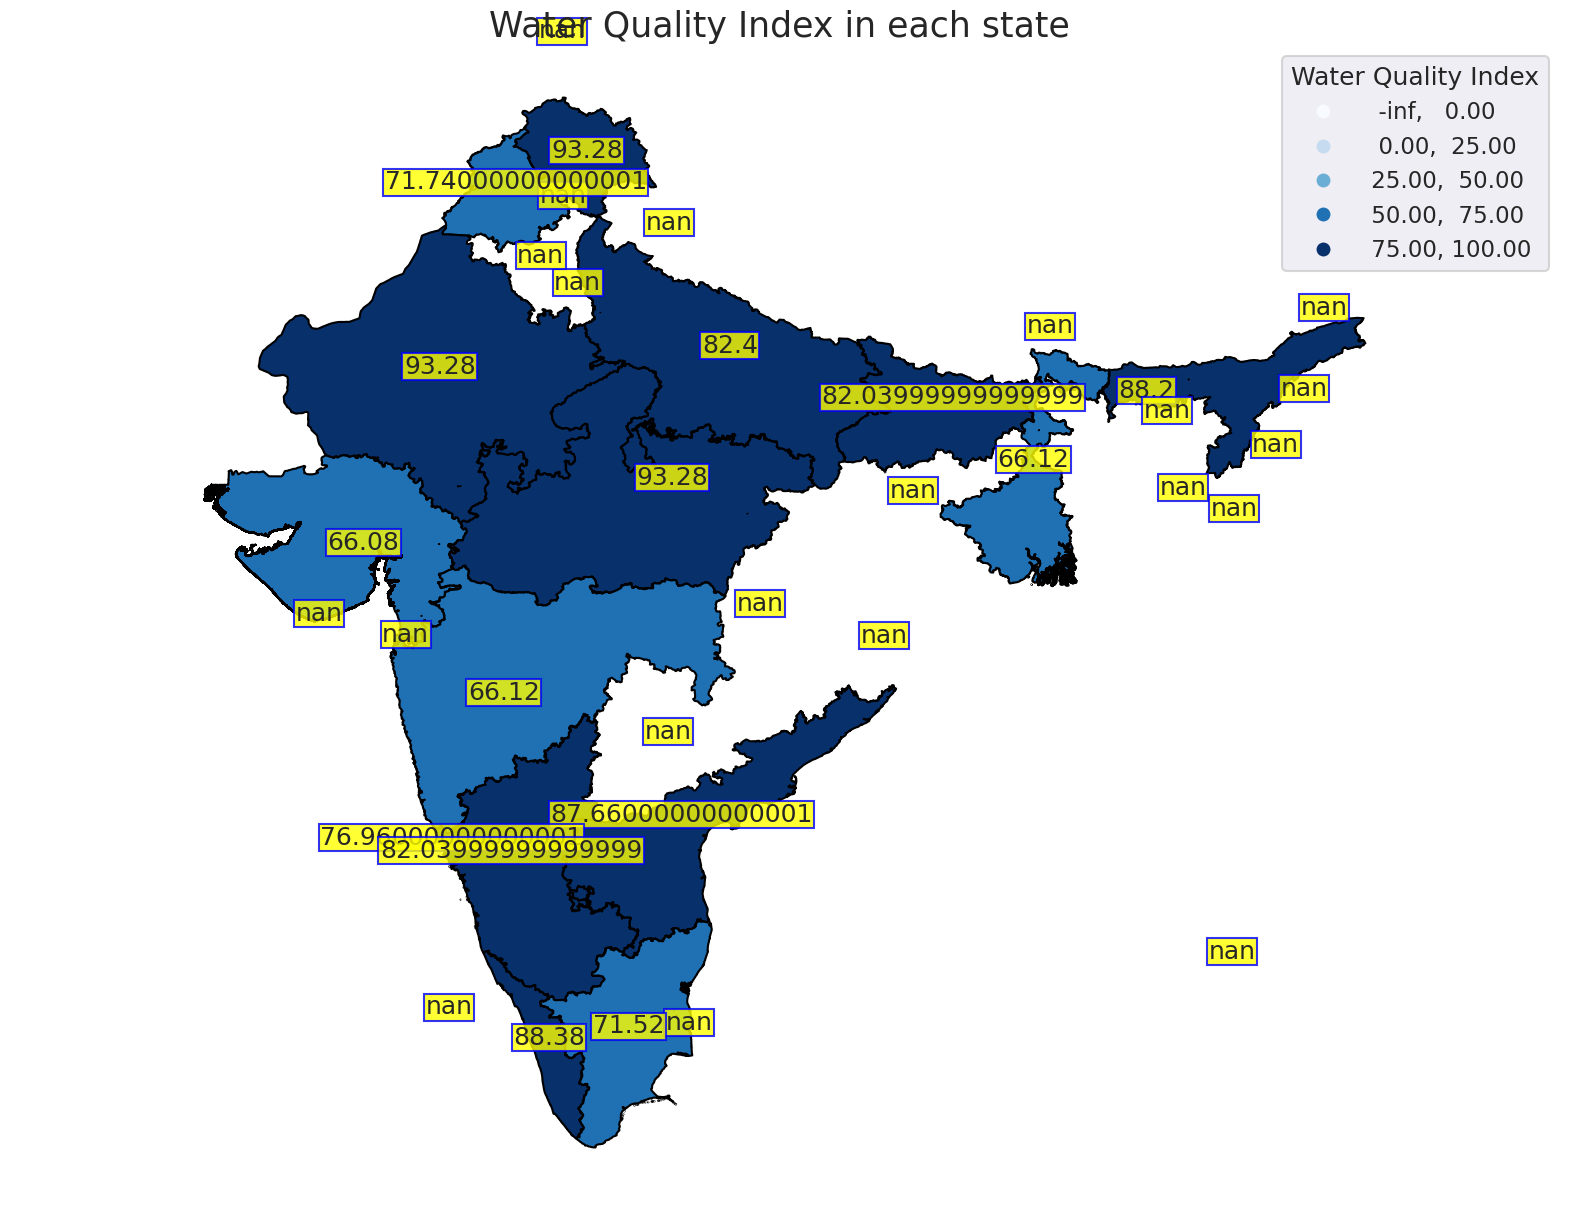

In [33]:
gdf = gdf.rename(columns={"st_nm": "state"})
merged = pd.merge(gdf, df , how='outer', on='state')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged = merged.drop_duplicates(subset ="state")

sns.set_context("talk")
sns.set_style("dark")
cmap = 'Blues'
figsize = (20, 15)
ax = merged.plot(column= 'wqi', cmap=cmap,
                          figsize=figsize, scheme='User_Defined',
                          classification_kwds=dict(bins=[0,25,50,75,100]),
                          edgecolor='black', legend = True)
for idx, row in merged.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['wqi'], horizontalalignment='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 1, 'edgecolor':'blue'})

ax.get_legend().set_title('Water Quality Index')
ax.set_title("Water Quality Index in each state ", size = 25)

ax.set_axis_off()
plt.axis('equal')
plt.show()

**Let us again convert the whole data in spark frame for further processes.**

In [34]:
spark_df = sqlContext.createDataFrame(df)

In [35]:
spark_df.show()

+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|station|            location|         state|               do|               ph|   co|               bod|                na|   fc|npH|ndo|nco|nbdo|nec|nna|               wph|               wdo|              wbdo|               wec|               wna|               wco|              wqi|  quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|   1312|GODAVARI AT JAYAK...|   Maharashtra|6.400000095367432|8.100000381469727|735.0|3.40000009536743

In [36]:
spark_df.createOrReplaceTempView("df_sql")

In [37]:
State = spark.sql("Select state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [38]:
Wqi = spark.sql("Select wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

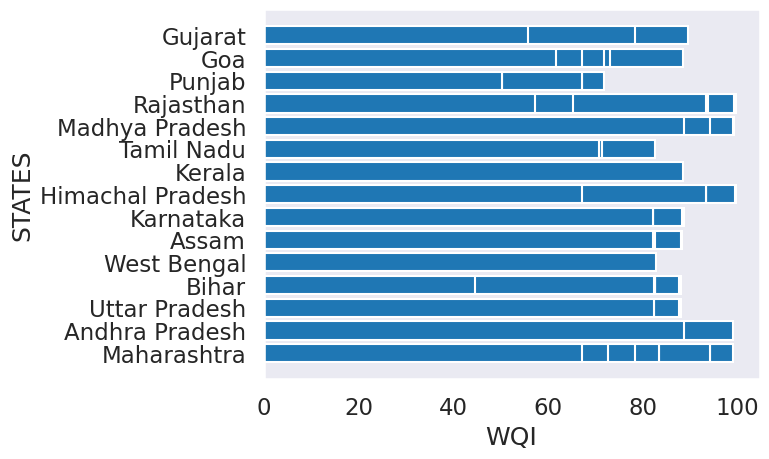

In [39]:
plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()



Now we apply machine learning and deep learning algorithms to predict the data.

**Non Deep Learning Based Linear Regresion Model**

In this, first data is converted which are required to predict WQI into vector form by using VectorAssembler. Then we normalize our data by using Normalizer.

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

Then import LinearRegression from pyspark.ml.regression and applied it to our normalized data. Afterthat, import Pipeline from pyspark.ml and include all those steps in the pipeline that have been done.

In [41]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features_norm",labelCol="wqi",maxIter=10,regParam=0.3,elasticNetParam=0.2)

In [42]:
from pyspark.ml import Pipeline

In [43]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])

**Before training, our data is randomly split in two parts so as to avoid overfitting and then training is done.**

In [44]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [45]:
model = pipeline.fit(train_data)

In [46]:
predictions = model.transform(train_data)

In [47]:
predictions.select("wqi","prediction").show()

+-----------------+-----------------+
|              wqi|       prediction|
+-----------------+-----------------+
|82.03999999999999|82.07791136615508|
|             82.4| 81.7777260123289|
|            66.12|67.44896955020245|
|            66.12|67.44896955020245|
|            66.12|67.44896955020245|
|            66.12|67.44896955020245|
|            66.12|67.44896955020245|
|             82.4| 81.7777260123289|
|             82.4| 81.7777260123289|
|77.36000000000001|77.83188841040361|
|77.36000000000001|77.83188841040361|
|            77.72|77.61871050255067|
|77.36000000000001|77.83188841040361|
|82.03999999999999|82.07791136615508|
|82.03999999999999|82.07791136615508|
|            66.12|67.44896955020245|
|82.03999999999999|82.07791136615508|
|            66.12|67.44896955020245|
|             82.4| 81.7777260123289|
|             82.4| 81.7777260123289|
+-----------------+-----------------+
only showing top 20 rows



**Now we check the performance of our model.**

In [48]:
model.stages[2].summary.r2

0.9770715083478158

**As the quality column is in string format so we convert our predicted data which are in numbers to their real string values and compared with the actual data.**

**Deep Learning Based Linear Regression Model**


In this first we collect our data in an array form and to reduce number of steps we converted our data in pandas frame.


In [49]:
df = spark_df.toPandas()

In [50]:
data = df.iloc[:,9:15].values
pred = df.iloc[:,21:22].values

In [51]:
from sklearn.model_selection import train_test_split
data_train,data_test,pred_train,pred_test = train_test_split(data,pred,test_size=0.20,random_state=1)
pred_train.shape

(357, 1)

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense

**Using TensorFlow backend**

Then we initialize model and add layers to it. Afterwards, the model is compiled with optimizer Adam and loss function mean squared error and then training is done.

In [53]:
model2 = Sequential()
model2.add(Dense(350,input_dim=6, activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(1,activation='linear'))

In [54]:
# Create an Adam optimizer instance with the desired parameters
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Compile the model using the optimizer instance
model2.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

In [55]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
perform = model2.fit(data_train,pred_train,epochs=50,batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3016.0078 - mse: 3016.0078
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 191.7529 - mse: 191.7529
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 41.4910 - mse: 41.4910
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3100 - mse: 9.3100
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5060 - mse: 2.5060
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8181 - mse: 0.8181
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4627 - mse: 0.4627
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1952 - mse: 0.1952
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1315 - mse: 0.1315
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0922 - mse: 0.0922
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0834 - mse: 0.0834
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0711 - mse: 0.0711
Epoch 13/50
12/12 ━━━━━━━

In [57]:
prediction = model2.predict(data_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


**Now we check performance of our model**



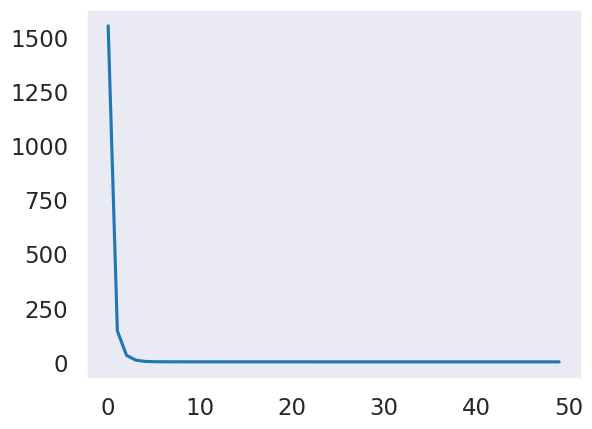

In [58]:
plt.plot(perform.history['loss'])

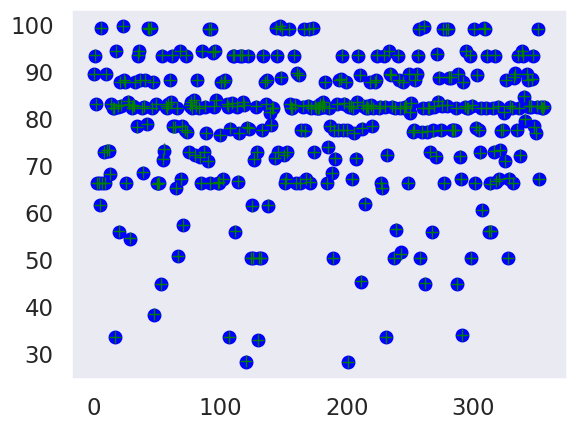

In [59]:
plt.plot(pred_train,'bo',prediction,'g+')

**Water Quality Prediction**


After predicting water quality index, now we classify water on the basis of its WQI and predict its quality.

In [60]:
spark_df = sqlContext.createDataFrame(df)

**Logistic Regression Model**

Here we are creating a logistic regression model because we don't have to predict a continuous value.

In [61]:
from pyspark.ml.feature import StringIndexer

As our quality column contains values in string format so first we indexed them using StringIndexer. Then data is converted which are required to predict water quality into vector form by using VectorAssembler. Then we normalize our data by using Normalizer.

In [62]:
indexer = StringIndexer(inputCol="quality",outputCol="label")
vectorAssembler2 = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco","wqi"], outputCol="features2")
normalizer2 = Normalizer(inputCol="features2",outputCol="features_norm2")

Then import LogisticRegression from pyspark.ml.classification and applied it to our normalized data. Afterthat, import Pipeline from pyspark.ml and include all those steps in the pipeline that have been done.

In [63]:
from pyspark.ml.classification import LogisticRegression

In [64]:
lor = LogisticRegression(featuresCol="features_norm2",labelCol="label",maxIter=10)

In [65]:
pipeline2 = Pipeline(stages=[indexer,vectorAssembler2,normalizer2,lor])

In [66]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [67]:
model3 = pipeline2.fit(train_data)

In [68]:
predictions2 = model3.transform(train_data)

Now let us check our predictions.

In [69]:
predictions2.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



Now we check performance of our model.

In [70]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
eval.evaluate(predictions2)

0.9888888888888889

As the quality column is in string format so we convert our predicted data which are in numbers to their real string values and compared with the actual data.

In [72]:
names = ["Very Poor","Poor","Good","Unsuitable","Excellent"]

In [73]:
predictions.createOrReplaceTempView("prediction_sql")

In [74]:
pred = spark.sql("Select prediction from prediction_sql")
pred = pred.rdd.map(lambda row : int(row.prediction)).collect()
qua = spark.sql("Select quality from prediction_sql")
qua = qua.rdd.map(lambda row : row.quality).collect()

In [82]:
for x in range(100):
    # Ensure pred[x] is within the valid range of indices for names
    index = pred[x] % len(names)
    print("Predicted:", names[index], "Actual:", qua[x])

Predicted: Good Actual: Very Poor
Predicted: Poor Actual: Very Poor
Predicted: Good Actual: Poor
Predicted: Good Actual: Poor
Predicted: Good Actual: Poor
Predicted: Good Actual: Poor
Predicted: Good Actual: Poor
Predicted: Poor Actual: Very Poor
Predicted: Poor Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Poor
Predicted: Poor Actual: Very Poor
Predicted: Poor Actual: Very Poor
Predicted: Poor Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Good Actual: Poor
Predicted: Unsuitable Actual: Very Poor
Predicted: Unsuitable Actual: Very Poor
Predicted: Poor Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Unsuitable Actual: Very Poor
Predicted: Good Actual: Very Poor
Predicted: Poor Actual: Very Poor
Pr